### Overview
In this notebook we study the formulation of the Reservoir Computing (RC) RNN. As an archetypal example, the RC implementation in time series for the Mackey-Glass chaotic system is recommended as a reference to this guide. This example can be found in the seminal paper: http://www.rctn.org/vs265/jaeger04-ESN.pdf; we encourage you to read this publication.

In this notebook, for the implementation of the RC we will use the library "pyESN" which is available in https://github.com/cknd/pyESN. In the same directory, you can find the Mackey-Glass example that was discussed in the class. We encourage you to explore this library.

We will employ the RC network to predict stock market prices. We will utilize time series data for the daily Amazon stock price (file: "amazon.txt"). You should study the Mackey-Glass example (mackey.ipynb) and then apply the RC for predicting the Amazon price.

You can observe that the input is a vetor of ones, so there is not input function. In this case the prediction is not a response to the previous signal. Essentially, the network is learning the pattern of the history (training set) and trying to make predictions based on that. That approach works pretty well because RC prerforms well in pattern recognition and analysis tasks.

We will predict 100 future time points by using the previous 1500 prices. As we discussed, RC is very sensitive to the hyper-parameter. So, you have to find the optimal set of hyper-parameter that gives the best predictions. For convenience, we are optimizing just two of the hyper-parameter, the spectrum radius  and a regularization term (noise). In particular, it adds noise in the hidden units to avoid the overfitting during the learning. The rest hyper-parameters are given.

The goals of this notebook are for you to:
1. learn the mechanics of RC
2. confirm that RC training is fast
3. learn how to use RC for forecasting
4. acknowledge that RC is sensitive to hyper-parameters (no free lunch)
5. learn how to optimize hyper-parameters of RC
6. evaluate RC forecasting

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### Overview for the pyESN library for the RC implementation


#### You call the RC as:
esn = ESN(n_inputs = 1, <br>
 $\quad$ $\quad$     n_outputs = #, <br>
 $\quad$ $\quad$     n_reservoir = #,<br>
 $\quad$ $\quad$     sparsity= #,<br>
 $\quad$ $\quad$     random_state= #, <br>
 $\quad$ $\quad$     spectral_radius = #,<br>
 $\quad$ $\quad$     noise= #)
<br> where # denotes the value that you choose.

##### Brief explanation of the parameters:
n_inputs: number of input dimensions <br>
n_outputs: numberr of output dimensions <br>
n_reservoir: number of reservoir neurons <br> 
random_state: seed for the random generator<br>
sparsity: proportion of recurrent weights set to zero <br>
spectral_radius: spectral radius of the recurrent weight matrix <br>
noise: noise added to each neuron (regularization) <br>


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# This is the library for the Reservoir Computing got it by: https://github.com/cknd/pyESN
from pyESN import ESN 
%matplotlib inline

### Read the data

Read your dataset from the file amazon.txt

In [4]:
# Read dataset amazon.txt
data = open("../dataset/amazon.txt").read().split()
data = np.array(data).astype('float64')

<div class='exercise'><b> Part 1: Predictions with the RC  </b></div>
Use the ESN from the pyESN library to employ an RC network. The task here is to predict two time points ahead by using the previous 1500 points and do that for 100 future points (check the figure below). So, in the end you will have a 100 time step prediction with prediction-window = 2. This will be your validation set.

In this section you should use the following hyper-parameters:  
- n_reservoir = 500
- sparsity=0.2
- random_state=23
- spectral_radius=1.2
- noise = 0.005

<br> *Hint: Follow the mackey.ipynb example in pyESN*
<img src="seq_prediction2.gif">




In [5]:
n_reservoir= 500
sparsity=0.2
rand_seed=23
spectral_radius = 1.2
noise = .0005


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 1500
future = 10
futureTotal=100
pred_tot=np.zeros(futureTotal)

for i in range(0,futureTotal,future):
    pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0]

Plot your prediction along with the ground truth (data) for the training and for the validation dataset

In [6]:
import seaborn as sns
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

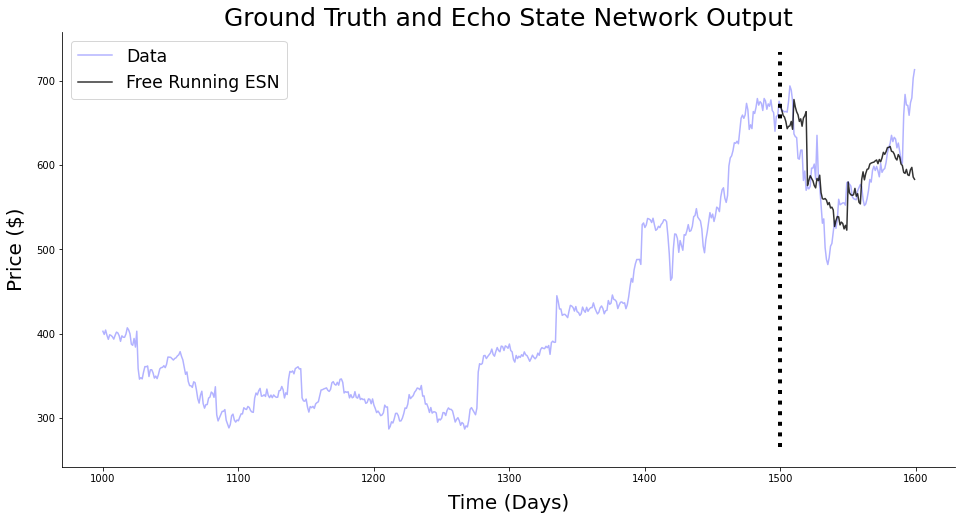

In [7]:
plt.figure(figsize=(16,8))
plt.plot(range(1000,trainlen+futureTotal),data[1000:trainlen+futureTotal],'b',label="Data", alpha=0.3)
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
plt.plot(range(trainlen,trainlen+futureTotal),pred_tot,'k',  alpha=0.8, label='Free Running ESN')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Ground Truth and Echo State Network Output', fontsize=25)
plt.xlabel(r'Time (Days)', fontsize=20,labelpad=10)
plt.ylabel(r'Price ($)', fontsize=20,labelpad=10)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()

Comment on the computational complexity of the training and evaluation of the RC. 

The computational complexity for an RC is quite small comparing standard RNNs. The reason is that we essentially train only the the weights of the output layer, which is a linear layer, so the computational complexity is the same with a linear regression task. In particular, the training complexity is of the order O(N) where N is the number of hidden units located in the reservoir. This makes the training and the evaluation very fast.

<div class='exercise'><b> Part 2: Hyper-parameters optimization </b></div>
We are asking you to find the optimal values for spectral_radius, noise  that gives the best prediction of this time series. In other words, we are looking for the hyper-parameters set that returns the minimum mean-square-error MSE. As previously, for each set of (spectral_radius, noise) you have to predict two time points ahead by using the previous 1500 points and do that for 100 steps as you did in part 1. These are essentially your validation set. Then calculate the MSE loss for the validation set and show through visualization which set gives the lowest MSE.
<br>

Hints:
- Build a function for the MSE
- Perform a grid search for the hyper parameters spectral_radius and noise
- Use the ranges: spectrum_radius = [0.5, 1.5] and noise=[0.0001, 0.01]
- For each set of (spectral_radius, noise) train the RC and make predictions as in part 1; these predictions are the validation sets
- For each validation set calculate the MSE and store it
- Make a 2D color plot to show the MSE for the different values of spectral_radius and noise

**Build a function for the MSE**

In [8]:
def MSE(yhat, y):
    return np.sqrt(np.mean((yhat.flatten() - y)**2))

**Perform a grid search**

In [9]:
n_reservoir= 500
sparsity   = 0.2
rand_seed  = 23
radius_set = [0.9,  1,  1.1]
noise_set = [ 0.001, 0.004, 0.006]

radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]



radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

trainlen = 1500
future = 2
futureTotal= 100

loss = np.zeros([radius_set_size, noise_set_size])

for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = rho,
          noise=noise)

        for i in range(0,futureTotal,future):
            pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
            prediction = esn.predict(np.ones(future))
            pred_tot[i:i+future] = prediction[:,0]
        
        loss[l, j] = MSE(pred_tot, data[trainlen:trainlen+futureTotal])        
        print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', MSE = ', loss[l][j] )


rho =  0.5 , noise =  0.0001 , MSE =  20.36705680058925
rho =  0.5 , noise =  0.0003 , MSE =  22.449560080752804
rho =  0.5 , noise =  0.0007 , MSE =  24.574909979417164
rho =  0.5 , noise =  0.001 , MSE =  25.862558649180805
rho =  0.5 , noise =  0.003 , MSE =  29.882933676855494
rho =  0.5 , noise =  0.005 , MSE =  32.639426142903474
rho =  0.5 , noise =  0.007 , MSE =  36.441245548689366
rho =  0.5 , noise =  0.01 , MSE =  44.77637915285575
rho =  0.7 , noise =  0.0001 , MSE =  19.560517901354192
rho =  0.7 , noise =  0.0003 , MSE =  20.127427950011196
rho =  0.7 , noise =  0.0007 , MSE =  20.818014277339948
rho =  0.7 , noise =  0.001 , MSE =  21.261426199560443
rho =  0.7 , noise =  0.003 , MSE =  23.270880660909835
rho =  0.7 , noise =  0.005 , MSE =  26.0613473315364
rho =  0.7 , noise =  0.007 , MSE =  30.298361979417038
rho =  0.7 , noise =  0.01 , MSE =  39.17074955773179
rho =  0.9 , noise =  0.0001 , MSE =  18.61297085998837
rho =  0.9 , noise =  0.0003 , MSE =  18.68181581

Make a 2D plot to show the MSE for the different values of spectral_radius and noise

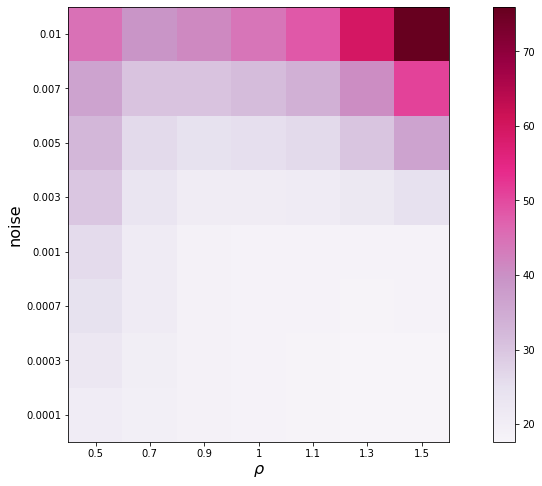

In [10]:
plt.figure(figsize=(16,8))
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuRd')
plt.xticks(np.linspace(0,radius_set_size-1,radius_set_size), radius_set);
plt.yticks(np.linspace(0,noise_set_size-1, noise_set_size), noise_set);
plt.xlabel(r'$\rho$', fontsize=16); plt.ylabel('noise', fontsize=16); 

# im.set_interpolation('bilinear')
cb = plt.colorbar(im); 

What is the optimal set? 

In [11]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum radius =  1.5 
noise =  0.0001 
MSE =  17.62740949047143


<div class='exercise'><b> Explore the RC ability in long predictions </b></div>

In the previous section you made predictions for two time points ahead by using the previous 1500 points and for 100 future points in total. In this section we are asking to explore if the prediction window (we used 2 in part 1 and part 2) affects the predictability. Using the optimal hyper parameters you found in part 2, perform the analysis for windows: 1, 2, 5, and 10. Does the MSE in the validation set depends on this window? 
<br>

**Hints:**

- Use the optimal set of hyper parameters that you found on part 2
- For this set repeat the calculation of the part 1 for different prediction windows and for the optimal window. In particular, instead of predicting two time points ahead you have to predict for 1, 2, 5, 10.
- For each prediction calculate the MSE in the validation set
- Plot the MSE as a function of the prediction window
- Comment  on your results (always!) 

In [12]:
n_reservoir= 500
sparsity=0.2
rand_seed=23
spectral_radius = 1.1
noise = .0001

# let k_set be an array with the prediction-window values
k_set = [1,2,5,10]

k_size = len(k_set)
loss_k = np.zeros(k_size)

for l in range(k_size):
    future = k_set[l]

    trainlen = 1500    
    futureTotal=100
    
    pred_tot=np.zeros(futureTotal)

    esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = spectral_radius,
          noise=noise)


    for i in range(0,futureTotal,future):
        pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
        prediction = esn.predict(np.ones(future))
        pred_tot[i:i+future] = prediction[:,0]
        
    loss_k[l] = MSE(pred_tot, data[trainlen:trainlen+futureTotal])   

Plot the MSE as a function of the prediction window

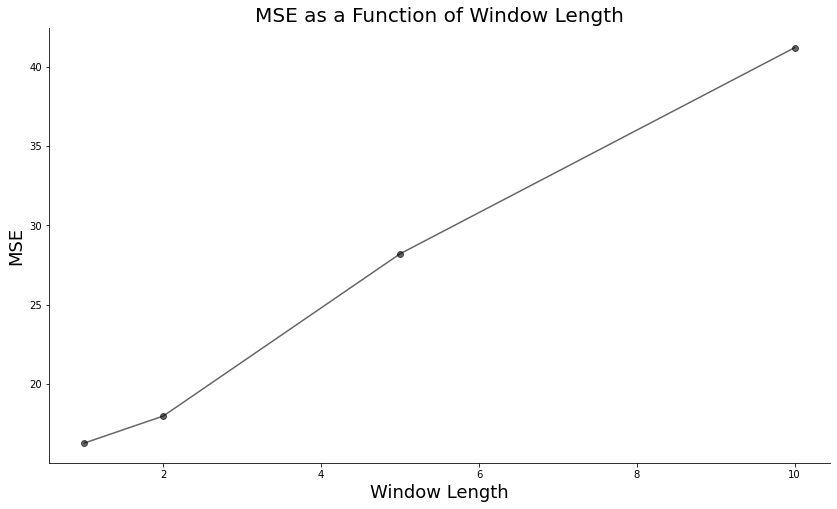

In [13]:
plt.figure(figsize=(14,8))
plt.plot(k_set, loss_k,'-ok', alpha=0.6)
plt.title('MSE as a Function of Window Length', fontsize=20)
plt.xlabel('Window Length', fontsize=18)
plt.ylabel('MSE', fontsize=18)
sns.despine()

How does the predictability depend on the length of the prediction? 

In the future predictions the error propagates in time and thus it increases in time. This is the reason that as longer is a prediction as more difficult to make it. We can see this behavior in the plot above, where the MSE is an increasing monotonically function of the prediction-window, hence longer predictions mean larger MSE.